In [1]:
import PyPDF2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
from transcript_functions import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Reading in proxy statements for Walmart from 2010 through 2019, reading each page of each PDF document as a separate row in the dataframe.

In [2]:
import pdftotext

df = pd.DataFrame(columns = ['raw_text','year'])

for k in range(10,20):
    
    pdfFileObj = open("C:/Users/rawin/Documents/GitHub/Capstone-Project/Proxies/Walmart/20%s_proxy.pdf"%(k),'rb')
    pdf = pdftotext.PDF(pdfFileObj)
    
    year = "20%s"%(k)
    company = "Walmart"

    sub_df = pd.DataFrame(columns = ['raw_text','year'])
    for page in pdf:
        x = page.replace('\n \n',', ')
        x = page.replace('\n',' ')
        sub_df = sub_df.append({'raw_text':x,'year':year,'company':company},ignore_index=True)

    df = pd.concat([df,sub_df],ignore_index=True)

In [3]:
df.shape

(976, 3)

In [4]:
#remove numbers
df['raw_text'] =  df['raw_text'].map(lambda x: re.sub(r'\d+', '', x))

stop_words = set(stopwords.words('english'))

punctuations = ['(',')',';',':','[',']',',','.',"''",'$','%','``',"’",".//","”",'-','˜˜','@','?','...']

#tokenize, lower-case, remove stopwords, and remove punctuations
df["tokens_clean"] = df["raw_text"].map(lambda x: [word.lower() for word in word_tokenize(x)
                                                   if word not in stop_words and word not in punctuations])

In [5]:
# tag Part of Speech
df["tokens_pos"] = df["tokens_clean"].map(nltk.pos_tag)
# filter words with pos not in pos_keep
pos_keep = ["NN", "NNS","VB", "VBD", "VBN", "VBP", "VBZ"] #take out "JJ", "JJR", "JJS"
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [tup for tup in x if tup[1] in pos_keep])

# lemmatize with POS
lemmatizer = WordNetLemmatizer()
df["tokens_final"] = df["tokens_pos"].map(lambda x: [lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x ])

df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if len(word)>3])

In [6]:
remove_words =['shareholders™','walmart','board','mr.','ms.','director','walton','committee','proxy','meeting','share',
               'vote','shareholder','plan','inc.','http','stock']

df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if word.lower() not in remove_words])

In [7]:
#keeping only rows that has more than 3 elements in tokens_final
df = df[df['tokens_final'].apply(lambda x: len(x) > 5)]

In [8]:
walmart_df = df[['year','company','tokens_final']]

walmart_df.to_csv(path_or_buf ='C:\\Users\\rawin\\Documents\\GitHub\\Capstone-Project\\Proxies\\All\\walmart.csv', 
                 index = False)

In [9]:
import gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import common_corpus, common_dictionary

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [10]:
dictionary = gensim.corpora.Dictionary(df["tokens_final"])

dictionary.filter_extremes(no_below=1, no_above=0.5) #, keep_n=100000)

bow_corpus = [dictionary.doc2bow(word) for word in df["tokens_final"]]

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, 
                                       passes=2, workers=2, chunksize=100, random_state=1000)

In [11]:
pp.pprint(lda_model.print_topics())

[   (   0,
        '0.053*"defer" + 0.048*"amount" + 0.048*"account" + '
        '0.045*"contribution" + 0.033*"participant" + 0.032*"cash" + '
        '0.025*"interest" + 0.023*"payment" + 0.022*"incentive" + '
        '0.021*"officer"'),
    (   1,
        '0.027*"audit" + 0.025*"compliance" + 0.024*"officer" + 0.022*"policy" '
        '+ 0.018*"risk" + 0.017*"guideline" + 0.016*"ownership" + '
        '0.015*"management" + 0.014*"performance" + 0.011*"transaction"'),
    (   2,
        '0.018*"amount" + 0.016*"cost" + 0.013*"include" + '
        '0.013*"relationship" + 0.011*"time" + 0.010*"base" + 0.009*"please" + '
        '0.008*"page" + 0.008*"material" + 0.008*"independence"'),
    (   3,
        '0.042*"performance" + 0.024*"incentive" + 0.019*"program" + '
        '0.016*"section" + 0.014*"goal" + 0.014*"amend" + 0.012*"officer" + '
        '0.012*"exchange" + 0.012*"associate" + 0.011*"store"'),
    (   4,
        '0.084*"audit" + 0.036*"service" + 0.035*"accountant" + 0.015

In [12]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

In [13]:
# pyLDAvis.show(vis)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.183484  0.061317       1        1  14.911856
10     0.159864  0.155852       2        1  11.798722
13    -0.145784 -0.043934       3        1   8.564557
12     0.141242  0.103534       4        1   8.560884
3     -0.040985  0.013341       5        1   7.686951
6      0.172584 -0.168060       6        1   7.112662
11    -0.152984 -0.015802       7        1   6.370261
5     -0.057347  0.115952       8        1   6.368690
14     0.026354  0.098154       9        1   5.696404
8      0.106644 -0.206675      10        1   4.930599
4      0.090859  0.055668      11        1   4.838127
0     -0.212055 -0.091499      12        1   4.634977
9      0.066450 -0.077807      13        1   3.966365
1      0.005475  0.042116      14        1   3.000254
2      0.023165 -0.042156      15        1   1.558692, topic_info=            Term         Freq        Total Category  logprob  loglift
491  performance  3361.000000  3361.000000  Default  30.0000  30.0000
89         audit  1208.000000  1208.000000  Default  29.0000  29.0000
612       amount  1250.000000  1250.000000  Default  28.0000  28.0000
147        defer   770.000000   770.000000  Default  27.0000  27.0000
44      material   625.000000   625.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
111  information    14.498119   812.519348  Topic15  -5.1329   0.1352
125       review    14.135787   735.023560  Topic15  -5.1582   0.2101
64        report    14.100945   787.081787  Topic15  -5.1606   0.1392
436         cash    13.007595  1266.993530  Topic15  -5.2413  -0.4175
200   management    12.587628  1110.695435  Topic15  -5.2742  -0.3187

[1064 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
2980     14  0.395284        *assumes
86        2  0.019862    abbreviation
86        4  0.079448    abbreviation
86        5  0.734891    abbreviation
86        6  0.099310    abbreviation
...     ...       ...             ...
2896     14  0.706623      ••oversees
2897     14  0.506553  ••pre-approves
2898     14  0.805706       ••reviews
2899     14  0.506914          ••sets
2834     15  0.645941           ••the

[4840 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 11, 14, 13, 4, 7, 12, 6, 15, 9, 5, 1, 10, 2, 3])

In [14]:
df.columns

Index(['raw_text', 'year', 'company', 'tokens_clean', 'tokens_pos',
       'tokens_final'],
      dtype='object')

## Finding the dominant topic in each page

In [15]:
def format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']]):
    # Init output
    page_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                page_topics_df = page_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    page_topics_df.columns = ['topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    page_topics_df = pd.concat([texts,page_topics_df], axis=1)
    return(page_topics_df)


df_topic_pages_keywords = format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']])

# Format
df_dominant_topic = df_topic_pages_keywords.reset_index()
df_dominant_topic = df_dominant_topic.drop('index',axis=1)

# Show
df_dominant_topic.head(10)

,year,tokens_final,topic,perc_contribution,topic_keywords
0,2010,"[street, website, www.walmartstores.com, notic...",8.0,0.5771,"material, receive, recipient, paper, instructi..."
1,NaN,NaN,6.0,0.3573,"proposal, receive, hold, record, instruction, ..."
2,2010,"[wal-mart, store, street, website, www.walmart...",3.0,0.6035,"performance, incentive, program, section, goal..."
3,2010,"[nonqualified, compensation, potential, paymen...",3.0,0.5683,"performance, incentive, program, section, goal..."
4,2010,"[compensation, store, compensation, amend, jan...",9.0,0.8801,"election, hold, nominee, power, proposal, incl..."
5,2010,"[election, nominee, name, statement, company, ...",6.0,0.9956,"proposal, receive, hold, record, instruction, ..."
6,2010,"[effect, broker, proposal, broker, occur, regi...",8.0,0.9963,"material, receive, recipient, paper, instructi..."
7,2010,"[revoke, revoke, record, holder, filing, write...",14.0,0.2578,"serve, chairman, experience, service, equity, ..."
8,2010,"[owner, hold, street, name, describe, bank, br...",14.0,0.6121,"serve, chairman, experience, service, equity, ..."
9,2010,"[michele, burn, burn, chairman, mercer, subsid...",14.0,0.9955,"serve, chairman, experience, service, equity, ..."


In [16]:
df_dominant_topic.shape

(976, 5)

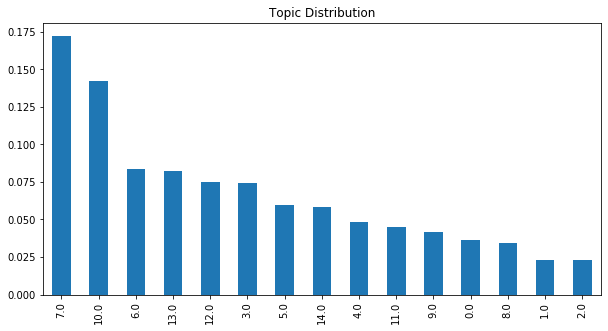

In [17]:
topic_counts = df_dominant_topic["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="Percentage",
                                       title="Topic Distribution",
                                       kind="bar", figsize=(10,5))

## Topic Trends

In [18]:
df_trend = pd.crosstab(df_dominant_topic["year"], df_dominant_topic["topic"], normalize="index")
years = [str(x) for x in df_trend.index]

In [19]:
df_trend

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
year,,,,,,,,,,,,,,,
2010,0.021053,0.010526,0.021053,0.147368,0.115789,0.063158,0.031579,0.105263,0.073684,0.042105,0.052632,0.042105,0.073684,0.115789,0.084211
2011,0.046154,0.000000,0.030769,0.046154,0.046154,0.092308,0.076923,0.153846,0.046154,0.046154,0.092308,0.076923,0.061538,0.107692,0.076923
2012,0.044776,0.014925,0.029851,0.044776,0.029851,0.074627,0.074627,0.179104,0.014925,0.059701,0.074627,0.059701,0.134328,0.119403,0.044776
2013,0.038462,0.051282,0.012821,0.115385,0.038462,0.051282,0.115385,0.128205,0.012821,0.064103,0.102564,0.064103,0.051282,0.064103,0.089744
2014,0.021505,0.032258,0.032258,0.032258,0.043011,0.075269,0.096774,0.172043,0.021505,0.053763,0.139785,0.064516,0.086022,0.053763,0.075269
2015,0.025210,0.016807,0.016807,0.109244,0.033613,0.050420,0.084034,0.168067,0.042017,0.050420,0.134454,0.025210,0.067227,0.109244,0.067227
2016,0.065421,0.028037,0.018692,0.074766,0.074766,0.028037,0.084112,0.214953,0.009346,0.028037,0.168224,0.037383,0.056075,0.056075,0.056075
2017,0.043860,0.026316,0.026316,0.035088,0.035088,0.052632,0.078947,0.192982,0.017544,0.026316,0.219298,0.043860,0.070175,0.078947,0.052632
2018,0.037037,0.018519,0.027778,0.064815,0.037037,0.064815,0.083333,0.203704,0.027778,0.027778,0.194444,0.037037,0.083333,0.064815,0.027778


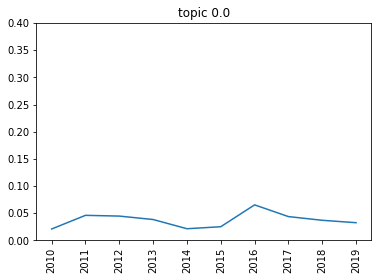

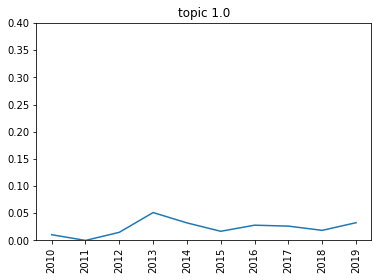

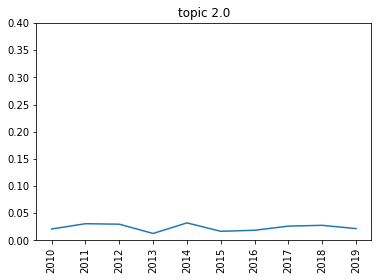

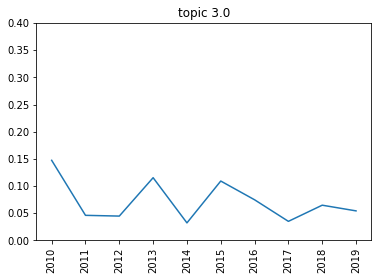

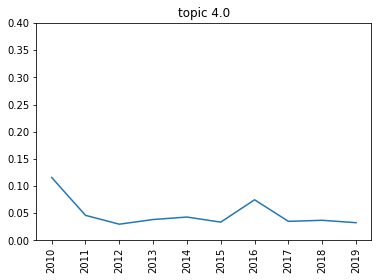

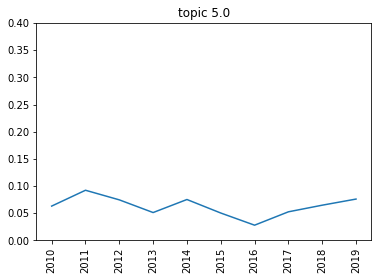

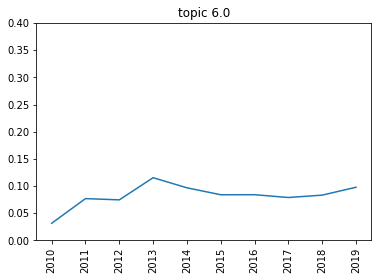

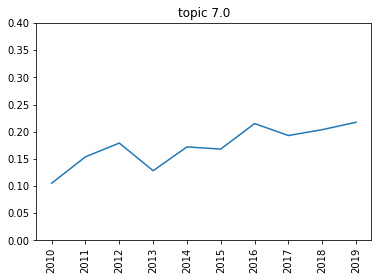

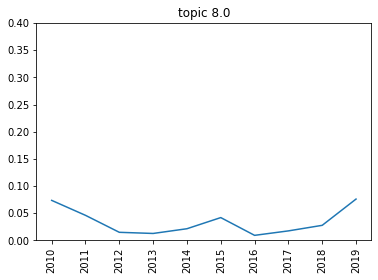

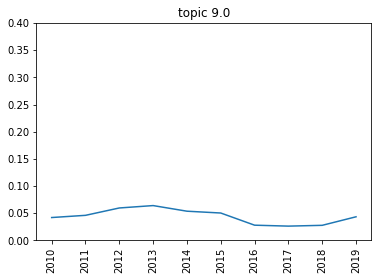

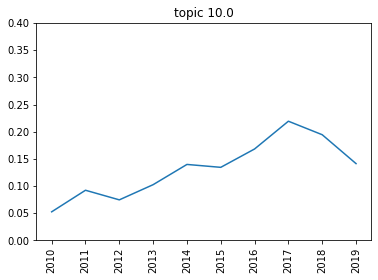

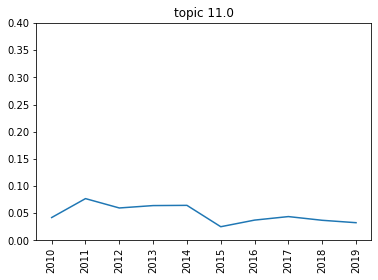

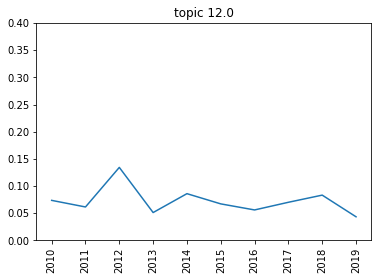

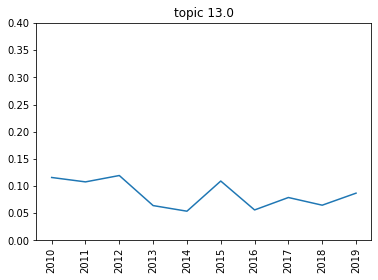

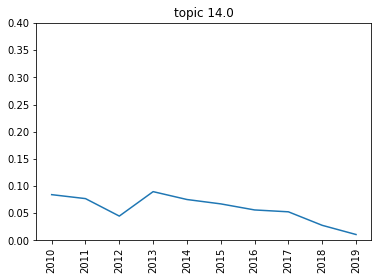

In [20]:
for topic in df_trend:
    fig, ax = plt.subplots()
    plt.plot(years, df_trend[topic].values)
    plt.ylim(0, 0.4)
    plt.xticks(years, years, rotation='vertical')
    plt.title("topic "+ str(topic))

### Checking for correlation with CPI 

Data is Consumer Price Index for all items less medical care in the US

In [21]:
df_cpi = pd.read_csv('CPI.csv')
df_cpi.columns = ['date','cpi']

In [22]:
df_trend = df_trend.reset_index()
df_trend_new = df_trend.drop('year', axis=1)

In [23]:
df_trend_new.corrwith(df_cpi['cpi'])

topic
0.0     0.238913
1.0    -0.338552
2.0     0.673556
3.0    -0.512339
4.0    -0.106610
5.0     0.641628
6.0    -0.102582
7.0     0.051038
8.0     0.025177
9.0    -0.200002
10.0    0.016099
11.0    0.580045
12.0    0.161061
13.0    0.023784
14.0   -0.177724
dtype: float64

### Checking for correlation with Labor Force Statistics/Unemployment Rate

In [24]:
labor = pd.read_excel('LaborForceStats.xlsx')

In [25]:
labor['avg'] = labor[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec']].mean(axis=1)
labor

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,avg
0,2010,9.8,9.8,9.9,9.9,9.6,9.4,9.4,9.5,9.5,9.4,9.8,9.3,9.608333
1,2011,9.1,9.0,9.0,9.1,9.0,9.1,9.0,9.0,9.0,8.8,8.6,8.5,8.933333
2,2012,8.3,8.3,8.2,8.2,8.2,8.2,8.2,8.1,7.8,7.8,7.7,7.9,8.075000
3,2013,8.0,7.7,7.5,7.6,7.5,7.5,7.3,7.2,7.2,7.2,6.9,6.7,7.358333
4,2014,6.6,6.7,6.7,6.2,6.3,6.1,6.2,6.1,5.9,5.7,5.8,5.6,6.158333
5,2015,5.7,5.5,5.4,5.4,5.6,5.3,5.2,5.1,5.0,5.0,5.1,5.0,5.275000
6,2016,4.9,4.9,5.0,5.0,4.8,4.9,4.8,4.9,5.0,4.9,4.7,4.7,4.875000
7,2017,4.7,4.6,4.4,4.4,4.4,4.3,4.3,4.4,4.2,4.1,4.2,4.1,4.341667
8,2018,4.1,4.1,4.0,4.0,3.8,4.0,3.8,3.8,3.7,3.8,3.7,3.9,3.891667
9,2019,4.0,3.8,3.8,3.6,3.6,3.7,3.7,3.7,3.5,3.6,3.5,3.5,3.666667


In [26]:
df_trend_new.corrwith(labor['avg'])

topic
0.0    -0.156143
1.0    -0.396145
2.0     0.098903
3.0     0.369036
4.0     0.474876
5.0     0.365831
6.0    -0.485130
7.0    -0.837613
8.0     0.151526
9.0     0.531755
10.0   -0.881740
11.0    0.631716
12.0    0.292228
13.0    0.557292
14.0    0.703309
dtype: float64

### Checking for correlation with WMT Stock Price

In [27]:
stocks = pd.read_csv('WMT.csv')

In [28]:
from datetime import datetime as dt

stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks = stocks.sort_values(by='Date',ascending=True)

In [29]:
stocks['Year'] = stocks['Date'].dt.year

In [30]:
stocks_new = stocks.groupby('Year')[['Close','Adj Close']].mean().reset_index()
stocks_new

,Year,Close,Adj Close
0,2010,52.700833,41.329478
1,2011,54.718333,43.993219
2,2012,67.682500,55.885999
3,2013,75.328333,63.681703
4,2014,77.716666,67.334563
5,2015,71.111667,63.070783
6,2016,69.830000,63.833105
7,2017,79.891666,75.149879
8,2018,92.692501,89.256581
9,2019,108.802499,107.159365


In [31]:
df_trend_new.corrwith(stocks_new['Adj Close'])

topic
0.0    -0.025468
1.0     0.461687
2.0    -0.041044
3.0    -0.363111
4.0    -0.515010
5.0    -0.038147
6.0     0.521743
7.0     0.731554
8.0     0.101341
9.0    -0.309095
10.0    0.643269
11.0   -0.489217
12.0   -0.278060
13.0   -0.450842
14.0   -0.820397
dtype: float64